In [1]:
import os
import json
from pathlib import Path
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np

from models.brain_class_encoder import BrainClassifierV1, BrainClassifierV3
from dataloaders.conditional_loaders import ClassConditionalLoader, ECOGLoader, get_word_from_filepath
import dataloaders.utils as data_utils

/home/passch/.conda/envs/diffwave/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


## Data Preparation

In [439]:
USE_PRECOMPUTED_SPLIT = False

SHUFFLING_SEED = 1919

In [485]:
rng = np.random.default_rng()

data_base_dir = Path('/home/passch/data/')
data_path = data_base_dir / 'HP1_ECoG_conditional/sub-002'
splits_path = data_base_dir / 'datasplits/HP1_ECoG_conditional/sub-002'

if USE_PRECOMPUTED_SPLIT:
    with open(splits_path / 'train.csv', 'r') as f:
        train_files = [fn.replace('.wav','.npy') for fn in f.read().split(',')]
    
    with open(splits_path / 'val.csv', 'r') as f:
        val_files = [fn.replace('.wav','.npy') for fn in f.read().split(',')]
    
    # n_classes = len(np.unique([get_word_from_filepath(file) for file in train_files]))
    # print(n_classes)

    # Set no. of classes to 55 even if dataset may lower actual number of classes. 
    # This ensures compatibility with the class-conditional pretraining model.
    n_classes = 55
    print(len(train_files), len(val_files))

    rng.shuffle(train_files)
    rng.shuffle(val_files)

else:
    COUNT_THRESHOLD = 13
    UNDERSAMPLE = True
    VAL_INSTANCES_PER_CLASS = 3

    all_files = sorted([fn for fn in os.listdir(data_path) if fn.endswith('.npy')])
    rng.shuffle(all_files)

    # Compute counts for all words
    words, counts = np.unique(
        [get_word_from_filepath(fn) for fn in all_files], 
        return_counts=True
    )

    # Keep only words above certain threshold
    words_to_keep = []
    for word, count in zip(*[words, counts]):
        if count >= COUNT_THRESHOLD:
            words_to_keep.append(word)

    train_files, val_files, full_files = [], [], []

    for word in words_to_keep:
        # if word == 'wel' or word == 'dag':
        #     continue
        word_files = [fn for fn in all_files if get_word_from_filepath(fn) == word]
        if UNDERSAMPLE:
            word_files = word_files[:COUNT_THRESHOLD]
        full_files.extend(word_files)
        val_files.extend(word_files[:VAL_INSTANCES_PER_CLASS])
        train_files.extend(word_files[VAL_INSTANCES_PER_CLASS:])
        # val_files.extend(
        #     rng.choice(word_files, size=2, replace=False)
        # )

    # rng.shuffle(full_files)

    # Make train and validation split
    # train_files, val_files = train_test_split(
    #     selected_files, 
    #     test_size=0.15, 
    #     random_state=SHUFFLING_SEED
    # )
    
    n_classes = len(words_to_keep)
    unique_words = sorted(words_to_keep)

    print('#Classes:', n_classes)
    print(len(train_files), len(val_files))

#Classes: 2
20 6


In [437]:
# Run this cell to only use the 6 most occuring words in the trainset, and undersample them to 7 instances each
# This leaves the valset untouched

COUNT_THRESHOLD = 10
UNDERSAMPLE = True


words, counts = np.unique(
    [get_word_from_filepath(fn) for fn in train_files], 
    return_counts=True
)

# Keep only words above certain threshold
words_to_keep = []
for word, count in zip(*[words, counts]):
    if count >= COUNT_THRESHOLD:
        print(word, ':', count)
        words_to_keep.append(word)
words_to_keep

new_train_files = []
new_val_files = []
for word in words_to_keep:
    word_files = [fn for fn in train_files if get_word_from_filepath(fn) == word]
    if UNDERSAMPLE:
        word_files = word_files[:COUNT_THRESHOLD]
    new_train_files.extend(word_files)

    word_files = [fn for fn in val_files if get_word_from_filepath(fn) == word]
    new_val_files.extend(word_files)


train_files = new_train_files
val_files = new_val_files
n_classes = len(words_to_keep)
print(n_classes)
len(train_files), len(val_files)

dag : 10
wel : 13
2


(20, 8)

In [452]:
val_files

['dag8.npy', 'dag11.npy', 'dag6.npy', 'wel3.npy', 'wel1.npy', 'wel18.npy']

In [415]:
if n_classes == 55:
    class_label_loader = ClassConditionalLoader(data_base_dir / 'HP_VariaNTS_intersection.txt')
else:
    # If using only subset of classes, use the unique words computed above
    class_label_loader = ClassConditionalLoader(words_file=None, words_list=unique_words)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, files) -> None:
        super().__init__()
        self.files=files
        # randomizer = np.random.choice(len(files), size=len(files), replace=False)
        # self.randomizer = {i: randomizer[i] for i in range(len(files))}
    def __getitem__(self, n:int):
        ecog = ECOGLoader.process_ecog(data_path / self.files[n])
        # try:
        #     n = self.randomizer[n]
        # except KeyError:
        #     raise IndexError
        word_vector = class_label_loader(self.files[n]).squeeze()
        # word_vector = class_label_loader.word_tokens[get_word_from_filepath(self.files[n])]
        # word = get_word_from_filepath(self.files[n])
        # return ecog, word # for SVM
        return ecog, word_vector # for MLP
    def __len__(self):
        return len(self.files)
    def labels(self):
        return [get_word_from_filepath(fp) for fp in self.files]

trainset = Dataset(train_files)
valset = Dataset(val_files)

# Oversample train set
# labels = trainset.labels()
# labels_unique, counts = np.unique(labels, return_counts=True)
# class_weights = {label: sum(counts)/c for label, c in zip(labels_unique, counts)}
# sample_weights = [class_weights[label] for label in labels]
# sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
sampler = None

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=8, num_workers=4, pin_memory=False, shuffle=False, drop_last=False, sampler=sampler)

valloader = torch.utils.data.DataLoader(
    valset, batch_size=8, num_workers=4, pin_memory=False, shuffle=False, drop_last=False)


### Fit SVC with and without LOO

In [486]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [487]:
X_train = np.stack([ECOGLoader.process_ecog(data_path/fn).flatten() for fn in train_files])
y_train = np.stack([get_word_from_filepath(fn) for fn in train_files])
X_test = np.stack([ECOGLoader.process_ecog(data_path/fn).flatten() for fn in val_files])
y_test = np.stack([get_word_from_filepath(fn) for fn in val_files])

clf = SVC(C=2)
clf.fit(X_train, y_train)
train_acc = clf.score(X_train, y_train)
val_acc = clf.score(X_test, y_test)

print(train_acc, val_acc)

1.0 0.5


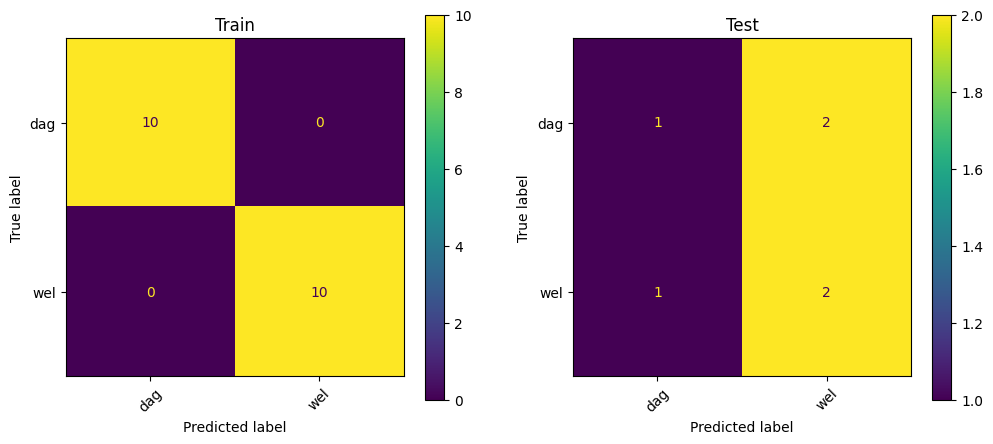

In [488]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
ax1.set_title('Train')
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax=ax1, xticks_rotation=45)
ax2 = plt.subplot(122)
ax2.set_title('Test')
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax2, xticks_rotation=45)
plt.show()

In [489]:
from sklearn.model_selection import KFold

X = np.stack([ECOGLoader.process_ecog(data_path/fn).flatten() for fn in full_files])
y = np.stack([get_word_from_filepath(fn) for fn in full_files])

crossval = KFold(n_splits=len(X))
print(f'Cross-validating with {crossval.get_n_splits()} splits:')

train_accs, test_accs = [], []


for i, (train_index, test_index) in enumerate(crossval.split(X)):

    # print(f"Fold {i}:")
    # print(f"  Train: index={train_index}")
    # print(f"  Test:  index={test_index}")

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf = SVC(C=2)
    clf.fit(X_train, y_train)

    train_accs.append(clf.score(X_train, y_train))
    test_accs.append(clf.score(X_test, y_test))

train_acc = round(np.mean(train_accs), 4)
test_acc = round(np.mean(test_accs), 4)
print('  Train Acc. :', train_acc)
print('  Test Acc.  :', test_acc)

Cross-validating with 26 splits:
  Train Acc. : 1.0
  Test Acc.  : 0.6154


In [258]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

<AxesSubplot: >

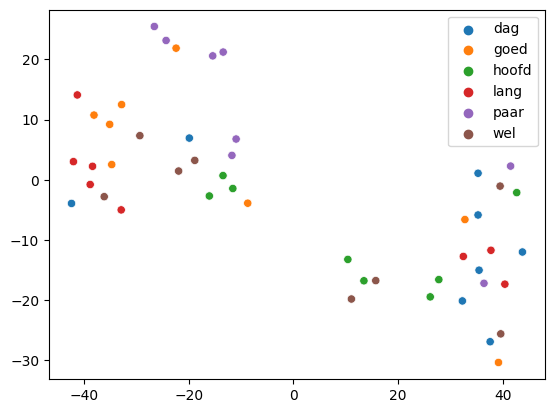

In [261]:
# plt.scatter(X_embedded[:,0], X_embedded[:,1], color=y)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y)#hue=[str(e) for e in y] )

### Test Oversampling works

In [6]:
labels = []
for _ in tqdm(range(100)):
    for data in trainloader:
        _, y = data
        # print(y)
        y = list(torch.argmax(y, dim=1, keepdim=True).squeeze().numpy())
        labels.extend(y)


100%|██████████| 100/100 [00:13<00:00,  7.60it/s]


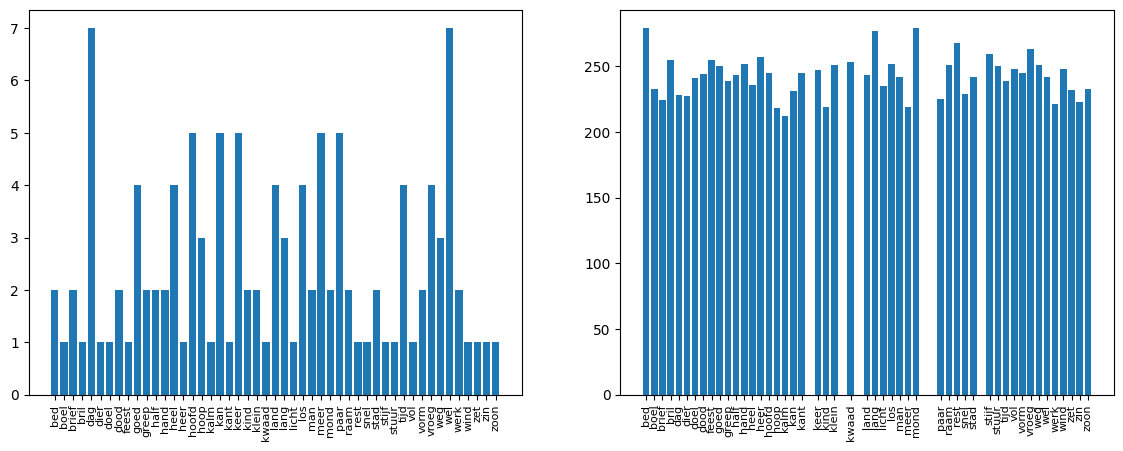

In [7]:
plt.figure(figsize=(14,5))

plt.subplot(121)
labels_unique, actual_counts = np.unique(trainset.labels(), return_counts=True)
plt.bar(labels_unique, actual_counts)
plt.xticks(labels_unique, np.unique(trainset.labels()), rotation=90, fontsize=8)

plt.subplot(122)
labels_unique, counts = np.unique(labels, return_counts=True)
plt.bar(labels_unique, counts)
plt.xticks(labels_unique, np.unique(trainset.labels()), rotation=90, fontsize=8)

# plt.tight_layout()
plt.show()

## Training

In [416]:
LEARNING_RATE = 1e-5
N_EPOCHS = 300

SAVE_ITER = 20

WEIGHT_DECAY = 0 # '0' to turn off
LR_DECAY_STEP_SIZE = None # 'None' to turn off scheduler
LR_DECAY_FACTOR = 0.01

In [417]:
# inp = torch.randn(8, 48, 55)
in_nodes = 48 * 55
model = torch.nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_nodes, in_nodes//2), 
    nn.ReLU(),
    # nn.BatchNorm1d(in_nodes//2),
    nn.LayerNorm(in_nodes//2),
    nn.Dropout(0.4),

    nn.Linear(in_nodes//2, in_nodes//4),
    nn.ReLU(),
    # nn.BatchNorm1d(in_nodes//4),
    nn.LayerNorm(in_nodes//4),
    nn.Dropout(0.3),

    nn.Linear(in_nodes//4, n_classes),
    nn.Softmax(1),
).cuda()
# model = nn.Sequential(
#     nn.Conv1d(48, 100, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.LayerNorm(55),
#     nn.MaxPool1d(kernel_size=2, stride=3),

#     nn.Conv1d(100, 200, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.LayerNorm(18),
#     nn.MaxPool1d(kernel_size=2, stride=2),
#     # nn.MaxPool2d(kernel_size=(1,2), stride=(1,2)),

#     nn.Flatten(),

#     nn.Linear(1800, 600),
#     nn.ReLU(),
#     nn.LayerNorm(600),
#     nn.Dropout(0.4),

#     # nn.Linear(1248, 624),
#     # nn.ReLU(),
    
#     nn.Linear(600, n_classes),
#     nn.Softmax(1),
# ).cuda()
# x = torch.randn(8,48,55).cuda()
# for l in model:
#     print(f'{l._get_name()}:')
#     x = l(x)
#     print(' ',x.shape)

# print('Final output:')
# print(' ',x.shape)

In [418]:
# model = BrainClassifierV1(in_nodes=127*2*SEGMENT_LENGTH, n_classes=n_classes).cuda()
# model = BrainClassifierV3(32, n_classes).cuda()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
if LR_DECAY_STEP_SIZE is not None:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_DECAY_STEP_SIZE, gamma=LR_DECAY_FACTOR)

start_epoch = 1
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2640, out_features=1320, bias=True)
  (2): ReLU()
  (3): LayerNorm((1320,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.4, inplace=False)
  (5): Linear(in_features=1320, out_features=660, bias=True)
  (6): ReLU()
  (7): LayerNorm((660,), eps=1e-05, elementwise_affine=True)
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=660, out_features=6, bias=True)
  (10): Softmax(dim=1)
)

In [403]:
# NOTE Change output name here for every experiment
ckpt_path = f'exp/Sub2_Full-Std_MLP_{n_classes}classes_LR{LEARNING_RATE}_dropout_layernorm_no-shuffle/'

os.makedirs(ckpt_path, exist_ok=False)
print(ckpt_path)

exp/Sub2_Full-Std_MLP_6classes_LR1e-05_dropout_layernorm_no-shuffle_2/


In [419]:
logs = {
    'train_loss_epoch': [], 'train_loss_batch': [], 'train_acc_epoch': [], 'train_acc_batch': [],
    'val_loss_epoch': [], 'val_loss_batch': [], 'val_acc_epoch': [], 'val_acc_batch': [],
}

In [420]:
for epoch in (pbar := tqdm(range(start_epoch, start_epoch+N_EPOCHS), desc='Training', ncols=125)):
    # TRAINING
    model.train()
    train_loss_epoch = 0.
    train_acc_epoch = 0.
    for i, data in enumerate(trainloader):
        x, y = data
        x = x.cuda()
        y = y.cuda()

        optimizer.zero_grad()
        y_pred = model(x)
        
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        
        train_loss_batch = loss.item()
        logs['train_loss_batch'].append(train_loss_batch)
        train_loss_epoch += train_loss_batch

        train_acc_batch = accuracy_score(
            torch.argmax(y, dim=1).cpu(), torch.argmax(y_pred, dim=1).cpu())
        logs['train_acc_batch'].append(train_acc_batch)
        train_acc_epoch += train_acc_batch
   
    train_loss_epoch /= len(trainloader)
    logs['train_loss_epoch'].append(train_loss_epoch)

    train_acc_epoch /= len(trainloader)
    logs['train_acc_epoch'].append(train_acc_epoch)

    # VALIDATING
    model.eval()
    val_loss_epoch = 0.
    val_acc_epoch = 0.
    for i, data in enumerate(valloader):
        x, y = data
        x = x.cuda()
        y = y.cuda()
        
        y_pred = model(x)
        
        loss = loss_fn(y_pred, y)
        
        val_loss_batch = loss.item()
        logs['val_loss_batch'].append(val_loss_batch)
        val_loss_epoch += val_loss_batch

        val_acc_batch = accuracy_score(
            torch.argmax(y, dim=1).cpu(), torch.argmax(y_pred, dim=1).cpu())
        logs['val_acc_batch'].append(val_acc_batch)
        val_acc_epoch += val_acc_batch

    val_loss_epoch /= len(valloader)
    logs['val_loss_epoch'].append(val_loss_epoch)

    val_acc_epoch /= len(valloader)
    logs['val_acc_epoch'].append(val_acc_epoch)

    # Update loss values in progress bar
    pbar.set_postfix({
        'Train Loss': f'{logs["train_loss_epoch"][-1]:.2f}', 
        'Val Loss': f'{logs["val_loss_epoch"][-1]:.2f}',
        'Train Acc': f'{logs["train_acc_epoch"][-1]:.3f}',
        'Val Acc': f'{logs["val_acc_epoch"][-1]:.3f}',
    })

    # Decay learning rate if specified
    if LR_DECAY_STEP_SIZE is not None:
        scheduler.step()

    # Save model checkpoint
    if epoch % SAVE_ITER == 0:
        torch.save(
            {'model_state_dict': model.state_dict()},
            os.path.join(ckpt_path, f'{epoch}.pkl')
        )

start_epoch = epoch + 1

Training: 100%|████████████| 300/300 [03:15<00:00,  1.54it/s, Train Loss=1.05, Val Loss=1.76, Train Acc=1.000, Val Acc=0.350]


Save logs to disk

In [421]:
with open(os.path.join(ckpt_path, 'logs.json'), "w") as f:
    json.dump(logs, f)

## Plotting Logged Metrics

In [15]:
with open(os.path.join(ckpt_path, 'logs.json'), "r") as f:
    logs = json.load(f)

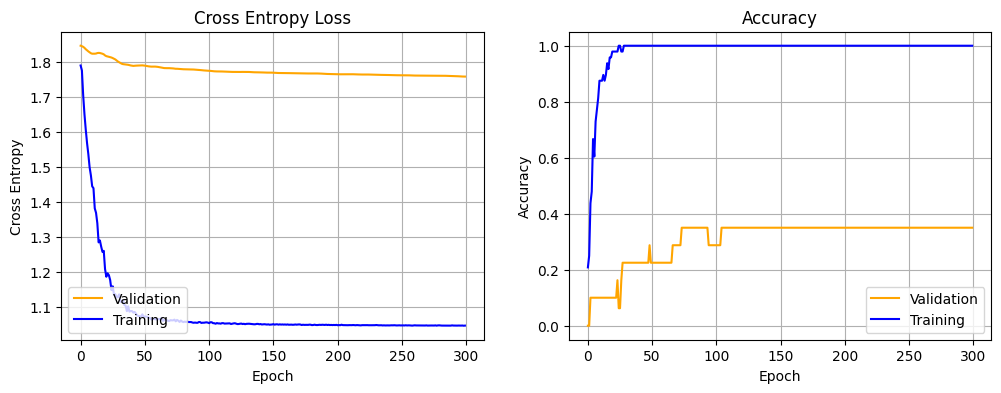

In [422]:
start_idx = 0
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.title('Cross Entropy Loss')
plt.plot(logs['val_loss_epoch'][start_idx:], color='orange', label='Validation')
plt.plot(logs['train_loss_epoch'][start_idx:], color='b', label='Training')
# plt.vlines(2000, 3.7, 4.0, colors='r', linestyles='--', alpha=0.5)
# plt.vlines(1100, 3.4, 4.1, colors='r', linestyles='--', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.legend(loc=3)
plt.grid()

plt.subplot(122)
plt.title('Accuracy')
plt.plot(logs['val_acc_epoch'][start_idx:], color='orange', label='Validation')
plt.plot(logs['train_acc_epoch'][start_idx:], color='b', label='Training')
# plt.vlines(2000, 0.0, 0.325, colors='r', linestyles='--', alpha=0.5)
# plt.vlines(1100, 0.0, 0.75, colors='r', linestyles='--', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=4)
plt.grid()

plt.savefig(os.path.join(ckpt_path, 'loss_progression'))
plt.show()

## Confusion Matrices

In [61]:
# Load model
epoch = 200
# load_ckpt_path = f'exp/brain_classifier_v1_{n_classes}classes_datasetv2_no-standardization'

ckpt = torch.load(os.path.join(ckpt_path, f'{epoch}.pkl'))
# model = BrainClassifierV1(in_nodes=2*32*SEGMENT_LENGTH, n_classes=n_classes).cuda()
# model = BrainClassifierV3(n_classes).cuda()
model.load_state_dict(ckpt['model_state_dict'])
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2640, out_features=1320, bias=True)
  (2): ReLU()
  (3): BatchNorm1d(1320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Dropout(p=0.4, inplace=False)
  (5): Linear(in_features=1320, out_features=660, bias=True)
  (6): ReLU()
  (7): BatchNorm1d(660, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=660, out_features=55, bias=True)
  (10): Softmax(dim=1)
)

In [423]:
all_preds_train = np.empty(0)
all_true_train = np.empty(0)
model.eval()
for i, data in enumerate(trainloader):
    x, y = data
    x = x.cuda()
    
    y_pred = model(x)
    all_preds_train = np.concatenate([all_preds_train, torch.argmax(y_pred, dim=1).cpu()])
    all_true_train = np.concatenate([all_true_train, torch.argmax(y, dim=1)])

cm_train = confusion_matrix(all_true_train, all_preds_train, labels=range(n_classes))

print('Unique classes predicted:', list(np.unique(all_preds_train)))

Unique classes predicted: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


In [426]:
all_preds_val = np.empty(0)
all_true_val = np.empty(0)
model.eval()
for i, data in enumerate(valloader):
    x, y = data
    x = x.cuda()

    y_pred = model(x)
    all_preds_val = np.concatenate([all_preds_val, torch.argmax(y_pred, dim=1).cpu()])
    all_true_val = np.concatenate([all_true_val, torch.argmax(y, dim=1)])

# cm_val = confusion_matrix(all_true_val, all_preds_val, labels=range(n_classes))
cm_val = confusion_matrix(all_true_val, all_preds_val, labels=np.unique(all_true_val))

print(all_preds_val)
print(all_true_val)
print('Unique classes predicted:', list(np.unique(all_preds_val)))

[1. 0. 3. 1. 1. 0. 0. 4. 5. 0. 1. 4. 0.]
[0. 0. 0. 1. 1. 2. 3. 4. 5. 5. 5. 5. 5.]
Unique classes predicted: [0.0, 1.0, 3.0, 4.0, 5.0]


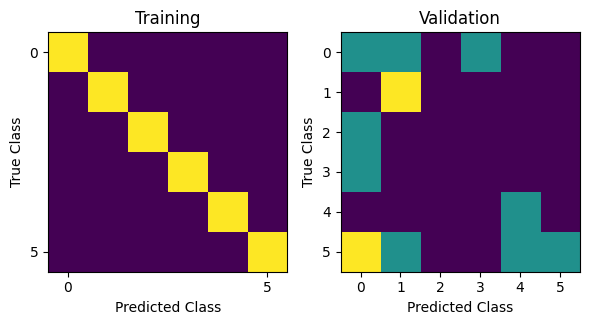

In [427]:
plt.figure(figsize=(6,4))
plt.subplot(121)
plt.imshow(cm_train)
plt.title('Training')
plt.ylabel('True Class')
plt.yticks(range(0,n_classes,5))
plt.xlabel('Predicted Class')
plt.xticks(range(0,n_classes,5))

plt.subplot(122)
plt.imshow(cm_val)
plt.title('Validation')
plt.ylabel('True Class')
plt.yticks(range(0,len(np.unique(all_true_val)),1))
plt.xlabel('Predicted Class')
plt.xticks(range(0,len(np.unique(all_true_val)),1))
# plt.grid()

plt.tight_layout()
plt.savefig(os.path.join(ckpt_path, f'conf_mat_e{epoch}'))
plt.show()

In [19]:
def get_word_from_token(token):
    return list(class_label_loader.word_tokens.keys())\
        [list(class_label_loader.word_tokens.values()).index(token)]

In [20]:
[get_word_from_token(t) for t in list(np.unique(all_preds_val))]

['hoofd', 'wel']